In [1]:
from askmendel.services.load_dataset import download_dataset
from askmendel.services.mendel import AskMendel

from askmendel.services.read_configs import read_configs
from askmendel.services.base_pipeline import run_pipeline
from askmendel.services.mendel import ask_mendel_for_plan, ask_mendel_for_result

configs = read_configs()

In [2]:
# Load dataset
adata = download_dataset()

Filtering cells...
Filtering genes...
Calculating QC metrics...


/home/codespace/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


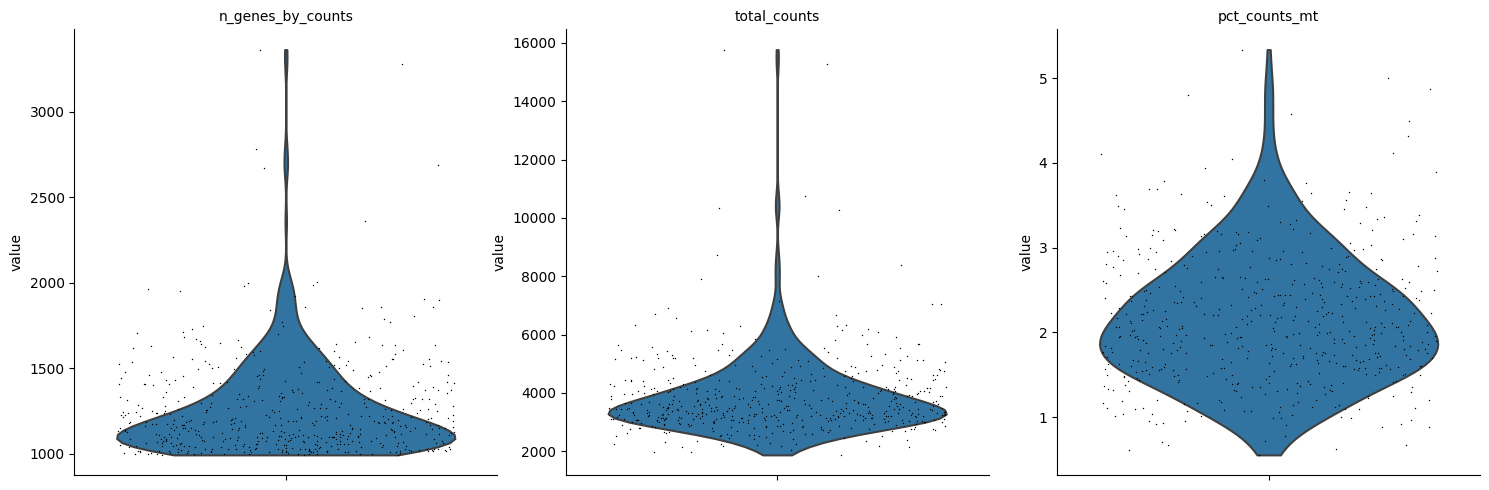

Normalizing data...
Logarithmize data...


<Figure size 640x480 with 0 Axes>

In [3]:
run_pipeline(adata, configs, show_plots=True)

In [4]:
prompt = "Can you plot `n_genes_by_counts` against `total_counts` in a scatter plot?"
plan = ask_mendel_for_plan(
    adata=adata,
    prompt=prompt
)

In [5]:
print(plan)

- Extract the `n_genes_by_counts` and `total_counts` columns from the `adata` object.
- Create a scatter plot with `n_genes_by_counts` on the x-axis and `total_counts` on the y-axis.
- Label the x-axis as "Number of Genes" and the y-axis as "Total Counts".
- Add a title to the plot.
- Show the plot.


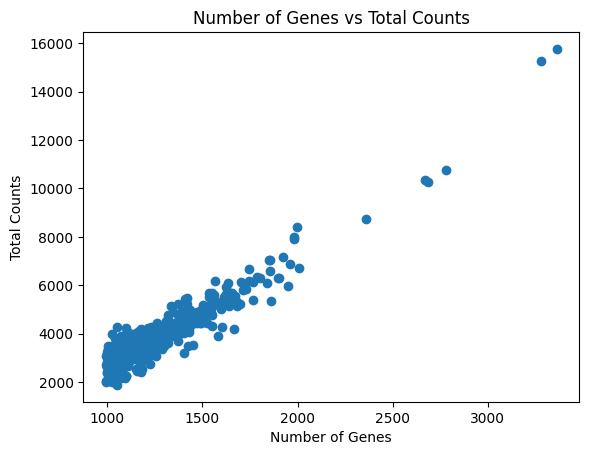

('Trying to run 0 time',
 AnnData object with n_obs × n_vars = 534 × 11519
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'log1p',
 'import scanpy as sc\nimport matplotlib.pyplot as plt\n\n# Extract the n_genes_by_counts and total_counts columns from the adata object\nn_genes_by_counts = adata.obs[\'n_genes_by_counts\']\ntotal_counts = adata.obs[\'total_counts\']\n\n# Create a scatter plot with n_genes_by_counts on the x-axis and total_counts on the y-axis\nplt.scatter(n_genes_by_counts, total_counts)\n\n# Label the x-axis as "Number of Genes" and the y-axis as "Total Counts"\nplt.xlabel("Number of Genes")\nplt.ylabel("Total Counts")\n\n# Add a title to the plot\nplt.title("Number of Genes vs Total Counts")\n\n# Show the plot\nplt.show()')

In [6]:
ask_mendel_for_result(adata=adata, prompt=prompt, plan=plan)

In [7]:
prompt = "Can you calculate highly variable genes using scanpy?"

plan = ask_mendel_for_plan(
    adata=adata,
    prompt=prompt
)

In [8]:
print(plan)

- Yes, I can calculate highly variable genes using scanpy.
- To calculate highly variable genes, I will use the `scanpy.pp.highly_variable_genes()` function from the Scanpy package.
- This function calculates the highly variable genes based on the dispersion and mean expression of each gene across cells.
- I will provide the necessary parameters such as `adata` (the AnnData object), `n_top_genes` (the number of top highly variable genes to select), and other optional parameters such as `flavor` (the method to use for calculating dispersion) and `subset_genes` (a list of genes to consider).
- After calculating the highly variable genes, I can access the results using the `adata.var` attribute, which will contain information about each gene's dispersion and whether it is considered highly variable or not.


In [9]:
altered_plan = """
    - Import the necessary libraries: scanpy
    - Preprocess the data by normalizing the counts and filtering out lowly expressed genes and cells using scanpy.pp.filter_genes() and scanpy.pp.filter_cells()
    - Calculate highly variable genes using scanpy.pp.highly_variable_genes()
    - Return the highly variable genes as a list or dataframe
"""
highly_variable_genes = ask_mendel_for_result(
    adata=adata, 
    prompt=prompt, 
    plan=plan
)

In [15]:
prompt = "Can you create a plot of highly variable genes on a single plot using scanpy?"

plan = ask_mendel_for_plan(
    adata=adata,
    prompt=prompt
)

In [16]:
print(plan)

To create a plot of highly variable genes on a single plot using scanpy, we can follow these steps:

1. Import the necessary libraries:
   - import scanpy as sc
   - import matplotlib.pyplot as plt

2. Load the dataset:
   - adata = sc.read("path_to_dataset")

3. Preprocess the data:
   - Perform any necessary preprocessing steps such as normalization, filtering, and scaling.

4. Identify highly variable genes:
   - Use the sc.pp.highly_variable_genes() function to identify highly variable genes in the dataset.
   - Set the parameters for this function, such as min_mean, max_mean, min_disp, and n_top_genes, based on the desired criteria for selecting highly variable genes.

5. Create a plot of highly variable genes:
   - Use the sc.pl.highly_variable_genes() function to create a plot of the highly variable genes.
   - Set the parameters for this function, such as log, show, save, and title, based on the desired visualization options.

6. Show or save the plot:
   - Use the plt.show() f

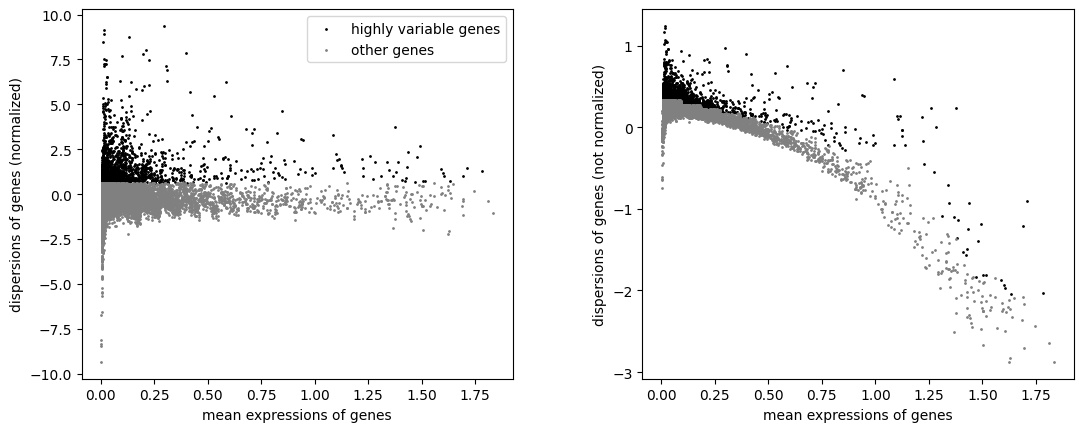

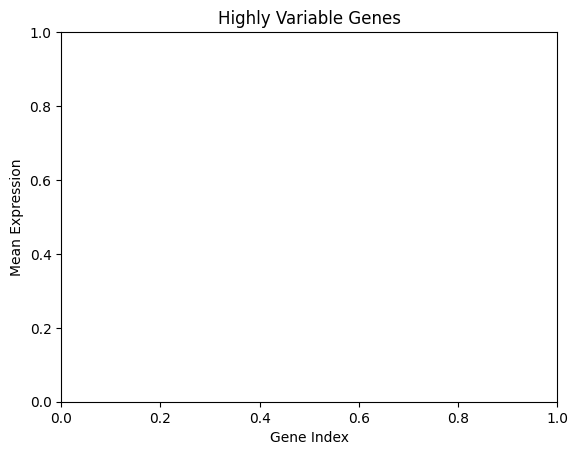

In [14]:
alternate_plan = """
To create a plot of highly variable genes using scanpy, we can follow these steps:

1. Import the necessary libraries:
   - import scanpy as sc
   - import matplotlib.pyplot as plt

2. Create the plot:
   - sc.pl.highly_variable_genes(adata)

3. Customize the plot if needed:
   - Set the title, axis labels, and other plot parameters using matplotlib functions.

4. Show the plot:
   - plt.show()

   """
highly_variable_genes = ask_mendel_for_result(
    adata=adata, 
    prompt=prompt, 
    plan=plan
)

In [18]:
prompt = "Can you do PCA on my `adata` using scanpy? Assume that data is already loaded and the preprocessing steps are taken care of already."

plan = ask_mendel_for_plan(
    adata=adata,
    prompt=prompt
)

print(plan)

Yes, I can perform PCA on your `adata` using scanpy. Here is the plan:

1. Import the necessary libraries: 
   - import scanpy as sc

2. Perform PCA on the `adata`:
   - Use the `sc.tl.pca()` function to perform PCA on the `adata`.
   - Specify the number of principal components to compute using the `n_comps` parameter.
   - Optionally, you can specify other parameters such as `svd_solver` and `random_state`.

3. Access the PCA results:
   - The PCA results will be stored in the `.obsm` attribute of the `adata` object.
   - Access the PCA results using `adata.obsm['X_pca']`.

4. Visualize the PCA results:
   - Use the `sc.pl.pca()` function to visualize the PCA results.
   - Specify the `color` parameter to color the cells based on a specific metadata column.
   - Optionally, you can specify other parameters such as `components` to visualize specific components.

5. Further analysis:
   - You can use the PCA results for downstream analysis such as clustering, visualization, and differe

In [20]:
alternate_plan = """
Yes, I can perform PCA on your `adata` using scanpy. Here is the plan:

1. Import the necessary libraries: 
   - import scanpy as sc

2. Perform PCA on the `adata`:
   - Use the `sc.tl.pca()` function to perform PCA on the `adata`.
   - Specify the number of principal components to compute using the `n_comps` parameter.
   - Optionally, you can specify other parameters such as `svd_solver` and `random_state`.
"""

pca = ask_mendel_for_result(
    adata=adata, 
    prompt=prompt, 
    plan=alternate_plan
)

In [23]:
prompt = """Can you plot the embedded graph using UMAP? Use these colors - 'CST3', 'NKG7', 'PPBP'. Use scanpy for this task and assume preprocessing is done for you already."""

plan = ask_mendel_for_plan(
    adata=adata,
    prompt=prompt
)

print(plan)

To plot the embedded graph using UMAP with the given colors, we can follow these steps:

1. Import the necessary libraries:
   - import scanpy as sc
   - import matplotlib.pyplot as plt

2. Create a new figure and axis for the plot:
   - fig, ax = plt.subplots()

3. Use the `sc.pl.umap()` function from scanpy to plot the UMAP embedding:
   - sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], ax=ax)

4. Customize the plot if needed:
   - Set the title of the plot using `ax.set_title()`
   - Set the x-axis label using `ax.set_xlabel()`
   - Set the y-axis label using `ax.set_ylabel()`

5. Show the plot:
   - plt.show()

By following these steps, we can plot the embedded graph using UMAP with the given colors 'CST3', 'NKG7', and 'PPBP'.


/home/codespace/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/codespace/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/codespace/.venv/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarni

<Figure size 800x600 with 0 Axes>

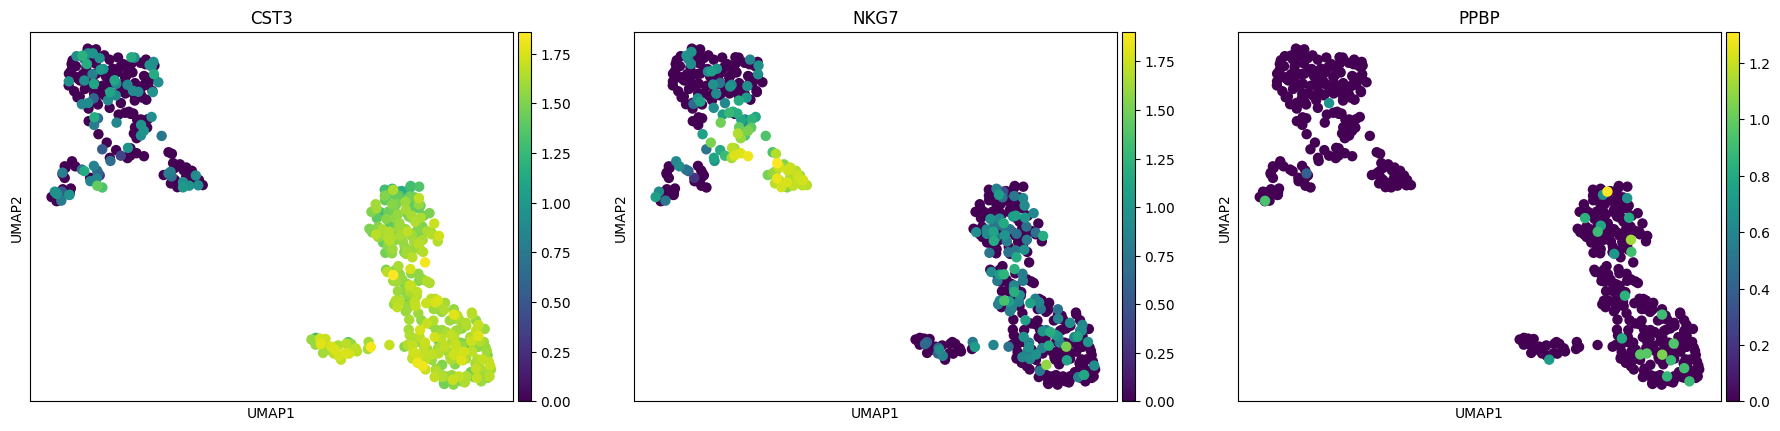

In [24]:
alternate_plan = """
To plot the embedded graph using UMAP and the given colors ('CST3', 'NKG7', 'PPBP'), we can follow these steps:

1. Import the necessary libraries:
   - import scanpy as sc
   - import matplotlib.pyplot as plt

2. Compute the UMAP embedding:
   - sc.pp.neighbors(adata)
   - sc.tl.umap(adata)

3. Create a scatter plot of the UMAP embedding:
   - plt.figure(figsize=(8, 6))
   - sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], legend_loc='on data')

4. Show the plot:
   - plt.show()

"""


pca = ask_mendel_for_result(
    adata=adata, 
    prompt=prompt, 
    plan=alternate_plan
)